# Welcome to GPyEm!

GPyEm is a package used to create independent multi-output emulators for cohort emulation studies using GPyTorch.

In this tutorial we will go through the choices users can make when building emulators in GPyEm.

# Installing GPyEm
## If you just want to use it...
```
pip install git+https://github.com/cwlanyon/GPyEm.git
```

## If you want to develop it...

Go to where you want to save your repo:
```
git clone https://github.com/cwlanyon/GPyEm.git
pip install -e GPyEm
```
So you can now import this in a python script anywhere you happen to be (no need to worry about paths etc):
```
from GPyEm import GPE_ensemble as GPE
```

## If you already have the repo on your computer...

Go to the location. E.g.
```
cd /home/me/Documents/code/GPyEm
```
Then call:
```
pip install -e .
```


In [1]:
#Import useful libraries

import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pyDOE import *

# Import GPyEm
from GPyEm import GPE_ensemble as GPE 

# Example 1: Changing the kernel

GPyEm has three choices of kernel built in, the Radial Basis function (RBF) kernel, the Matern kernel and the periodic kernel.

There is currently no option to combine kernels, but custom kernels can be added in a users personal installation by amending the GPE_ensemble and GP_functions files in the GPyEm folder (if you chose the development option when installing).

Here we illustrate the three kernel choices whilst emulating the function $f(\theta)=sin(3\theta)$.

It should be noted that the periodic kernel performs well here as the function we are emulating is periodic, in cases where this is not true the periodic kernel will not necessarily be a good choice.

### Define problem

In [2]:
lb= 0. #lower bound
ub = 20. # upper bound
p = 100 #observations

theta = torch.linspace(lb,ub,p) # parameter values

In [3]:
def oneD_func(theta): # define f
    return torch.sin(3*theta)

Text(0.5, 0, '$\\theta$')

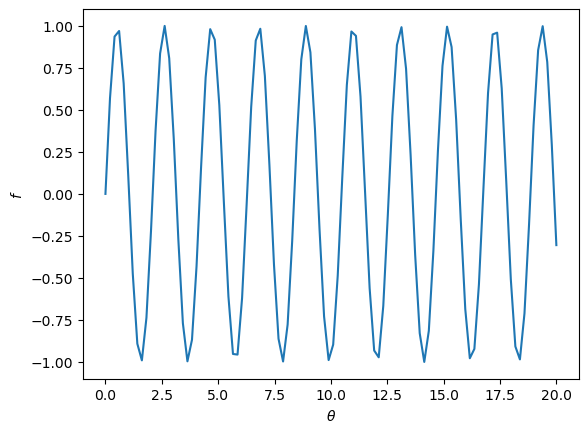

In [4]:
plt.plot(theta,oneD_func(theta)) # plot f
plt.ylabel('$f$')
plt.xlabel('$\\theta$')

### Train emulators

In [5]:
X=theta[:,None]
y=oneD_func(theta)[:,None]

# Split data into training and testing

theta_train, theta_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)

### Generate an emulator with an RBF kernel

In [6]:
emulator_rbf=GPE.ensemble(theta_train,y_train,kernel='RBF') 

0


### Generate an emulator with a matern 0.5 kernel

In [7]:
emulator_matern=GPE.ensemble(theta_train,y_train,kernel='matern',kernel_params=.5) 
# kernel params for Matern kernel accepts 0.5, 1.5, 2.5

0


### Generate an emulator with a periodic kernel

In [8]:
emulator_periodic=GPE.ensemble(theta_train,y_train,kernel='periodic') 

0


### Evaluate emulators

In [9]:
emulator_rbf.R2(theta_test,y_test)

tensor([0.0486], grad_fn=<RsubBackward1>)

In [10]:
emulator_matern.R2(theta_test,y_test)

tensor([0.8885], grad_fn=<RsubBackward1>)

In [11]:
emulator_periodic.R2(theta_test,y_test)

tensor([1.0000], grad_fn=<RsubBackward1>)

### Plot emulators

In [12]:
theta_ex = torch.linspace(lb,ub+10,1000) # Extend +10 past upper bound

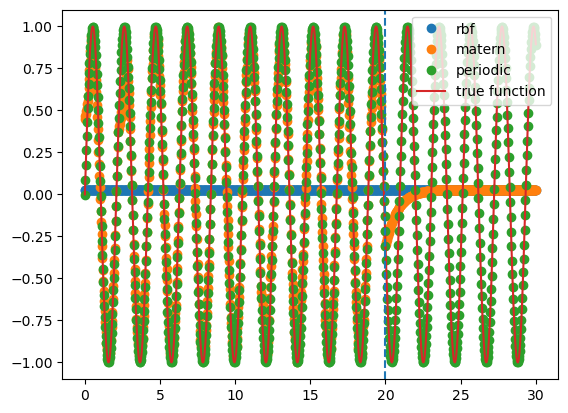

In [13]:
plt.plot(theta_ex,emulator_rbf.predict(theta_ex).detach().numpy(),'o')
plt.plot(theta_ex,emulator_matern.predict(theta_ex).detach().numpy(),'o')
plt.plot(theta_ex,emulator_periodic.predict(theta_ex).detach().numpy(),'o')
plt.plot(theta_ex,oneD_func(theta_ex))
plt.axvline(x=ub,linestyle='--')
plt.legend(['rbf','matern','periodic','true function'])

We can see here that the RBF has struggled to emulate the rapid oscillations and simply predicts the mean (0), the matern kernel follows the oscillations slightly more well but returns to the mean outside of the training data and the periodic kernel follows the pattern even when predicting outside of the training data.

# Example 2: Changing the mean

GPyEm has three possible mean functions: zero-mean, where the mean is fixed at zero and not learned; constant mean, where the mean is a constant value that is learned during GPE training and a linear mean, where $\mu = \beta_0 + \sum\beta_i\theta_i$ is a linear sum of the input parameters and the $\beta_i$ are learned during the training step (this is similar to performing a linear regression and then setting that as the mean of the GP). 

We illustrate these three means using the two output function from tutorial 1 

$$ f(\theta)=\begin{cases}
f_1(\theta)=\frac{\sin(2\theta)}{\theta} \\
f_2(\theta)=\theta
\end{cases}
$$

### Define problem

In [14]:
lb= 0.1 # lower bound
ub = 10 # upper bound
p = 100 # observations


theta = torch.linspace(lb,ub,p) # parameter sample

In [15]:
def twoD_func(theta): # define f
    out=torch.stack([torch.sin(2*theta)/theta,theta],axis=1)
    return out

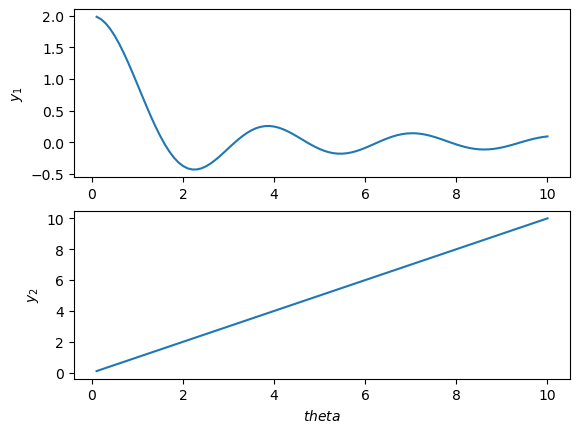

In [16]:
fig, axs = plt.subplots(2) # plot f
axs[0].plot(theta,twoD_func(theta)[:,0])
axs[1].plot(theta,twoD_func(theta)[:,1])
axs[0].set(ylabel='$y_1$');
axs[1].set(xlabel='$theta$', ylabel='$y_2$');

### Train emulators

In [17]:
X=theta[:,None]
y=twoD_func(theta)

# Split data into training and testing
theta_train, theta_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)

### Emulator with zero mean

In [18]:
emulator_zero=GPE.ensemble(theta_train,y_train,mean_func='zero') 

0
1


### Emulator with constant mean

In [19]:
emulator_constant=GPE.ensemble(theta_train,y_train,mean_func='constant') 

0
1


### Emulator with zero mean

In [20]:
emulator_linear=GPE.ensemble(theta_train,y_train,mean_func='linear') 

0
1


### Evaluate emulators

In [21]:
emulator_zero.R2(theta_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [22]:
emulator_constant.R2(theta_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [23]:
emulator_linear.R2(theta_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

### Evaluate emulators outside of training space

In [24]:
theta_ex = torch.linspace(lb,ub+20,100)

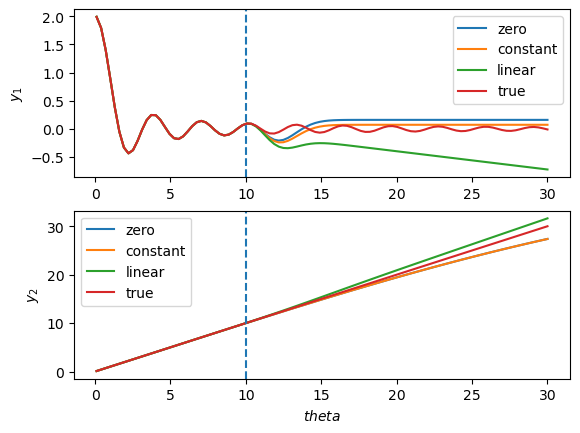

In [25]:
fig, axs = plt.subplots(2)
axs[0].plot(theta_ex,emulator_zero.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,emulator_constant.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,emulator_linear.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,twoD_func(theta_ex)[:,0])
axs[0].axvline(x=10,linestyle='--')
axs[1].plot(theta_ex,emulator_zero.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,emulator_constant.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,emulator_linear.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,twoD_func(theta_ex)[:,1])
axs[1].axvline(x=10,linestyle='--')
axs[0].set(ylabel='$y_1$');
axs[1].set(xlabel='$theta$', ylabel='$y_2$'); 

axs[0].legend(['zero','constant','linear','true']);
axs[1].legend(['zero','constant','linear','true']); 

Here we can see that in $f_1$, the oscilating case the constant mean remains closest to the true values outside of the training space, whereas the zero-mean emulator returns to 0 and the linear mean diverges from the true function. In the $f_2$ case, the linear mean is much more able to extrapolate as the zero and constant mean cases begin to diverge from the true function. 

# Example 3: Changing the training iterations

GPyEm emulators are trained using GP regression with stochastic gradient descent performed by the ADAM algorithm. The base number of iterations is set to 1000, but this can be altered by the user. Here we train three emulators with 0, 100 and 1000 iterations.


In [76]:
emulator_0=GPE.ensemble(theta_train,y_train,mean_func='linear',training_iter=0) 

0
1


In [77]:
emulator_100=GPE.ensemble(theta_train,y_train,mean_func='linear',training_iter=100) 

0
1


In [78]:
emulator_1000=GPE.ensemble(theta_train,y_train,mean_func='linear',training_iter=100) 

0
1


In [79]:
emulator_0.R2(theta_test,y_test)

tensor([0.7374, 0.9839], grad_fn=<RsubBackward1>)

In [80]:
emulator_100.R2(theta_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [81]:
emulator_1000.R2(theta_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [82]:
emulator_0.predict_sample(theta_ex,n=1)[:,0][:,0]

tensor([ 1.3025,  0.8626,  1.0024,  1.0042,  0.8171,  0.6602,  0.0729, -0.4236,
         1.0471, -0.1476,  0.0341,  0.4773,  0.3281, -0.1025,  0.2340,  0.2516,
         0.3846,  0.3139,  0.3739,  0.0599,  0.0982,  0.0496,  0.4044,  0.7955,
         0.1686,  0.6547,  0.2951, -0.5780,  0.6594,  0.3234,  0.3306,  0.1001,
         0.3963,  0.4207,  0.0544,  0.6186,  0.8086,  0.7135,  0.4936,  1.0006,
         1.3640,  1.7221,  1.9860,  1.6776,  2.4253,  2.1010,  2.9211,  2.4688,
         3.0019,  2.9289,  4.1762,  3.6878,  2.7061,  2.7670,  3.4844,  3.0037,
         3.4774,  3.8941,  2.9502,  3.6042,  3.4298,  3.3769,  3.6144,  3.8141,
         4.0961,  3.4075,  4.2615,  4.4875,  3.9106,  5.1200,  4.8861,  4.6327,
         5.2584,  4.8908,  4.7131,  4.5869,  4.5480,  5.0633,  5.0562,  4.6435,
         3.8676,  4.4517,  4.5989,  4.9005,  4.7017,  4.8683,  5.1442,  6.1373,
         5.3589,  6.5969,  6.4672,  5.7962,  5.9275,  6.2565,  6.5098,  6.4233,
         5.8313,  4.9286,  5.2398,  6.04

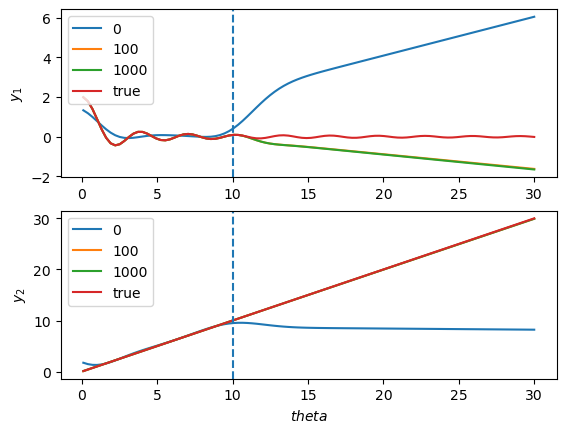

In [83]:
fig, axs = plt.subplots(2)
axs[0].plot(theta_ex,emulator_0.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,emulator_100.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,emulator_1000.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,twoD_func(theta_ex)[:,0])
axs[0].axvline(x=10,linestyle='--')
axs[1].plot(theta_ex,emulator_0.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,emulator_100.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,emulator_1000.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,twoD_func(theta_ex)[:,1])
axs[1].axvline(x=10,linestyle='--')
axs[0].set(ylabel='$y_1$');
axs[1].set(xlabel='$theta$', ylabel='$y_2$'); 

axs[0].legend(['0','100','1000','true']);
axs[1].legend(['0','100','1000','true']); 

We can see here that the training_iter=100 and 100 emulators well fit the data within the training regime. The training_iter=0 emulator has been conditioned on the training points, but still does not well aproximate the true function in the sinusoidal case. 

# Example 4: Saving and loading emulators

You can save and load emulator model states by changing the options in emulator creation.


First we generate a new emulator, and set the save parameter to True and the save_loc parameter to the location where we want to save our model state.

In [92]:
emulator_save=GPE.ensemble(theta_train,y_train,mean_func='linear',save=True,save_loc='save_example') 

0
1


You can also save the model states after creating the emulator by using the save_emulator_state function:

In [94]:
emulator_save=GPE.ensemble(theta_train,y_train,mean_func='linear') 

0
1


In [98]:
emulator_save.save_emulator_state('save_example')

We can view the hyperparameters for the emulator by loading the file:

In [99]:
torch.load('save_example')

[OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-14.8209])),
              ('likelihood.noise_covar.noise_prior.a', tensor([0.1500])),
              ('likelihood.noise_covar.noise_prior.b', tensor([1.5000])),
              ('likelihood.noise_covar.noise_prior.sigma', tensor([0.1000])),
              ('likelihood.noise_covar.noise_prior.tails.loc', tensor([0.])),
              ('likelihood.noise_covar.noise_prior.tails.scale',
               tensor([0.1000])),
              ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
               tensor(1.0000e-04)),
              ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
               tensor(inf)),
              ('covar_module.raw_outputscale', tensor(6.4183)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[-0.2611]])),
              ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.base_kernel.r

To load an emulator with the same model states we generate a new emulator with the same structure as the previous one and use the load parameter:

In [100]:
emulator_load=GPE.ensemble(theta_train,y_train,mean_func='linear',load=True,save_loc='save_example') 

0
1


We can check that emulator_load has the same hyperparameters as emulator_save:

In [101]:
states=[]
for model in emulator_load.models:
    states.append(model.state_dict())
    
states

[OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-14.8209])),
              ('likelihood.noise_covar.noise_prior.a', tensor([0.1500])),
              ('likelihood.noise_covar.noise_prior.b', tensor([1.5000])),
              ('likelihood.noise_covar.noise_prior.sigma', tensor([0.1000])),
              ('likelihood.noise_covar.noise_prior.tails.loc', tensor([0.])),
              ('likelihood.noise_covar.noise_prior.tails.scale',
               tensor([0.1000])),
              ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
               tensor(1.0000e-04)),
              ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
               tensor(inf)),
              ('covar_module.raw_outputscale', tensor(6.4183)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[-0.2611]])),
              ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.base_kernel.r